In [1]:
import os
from time import time
import yaml

from argparse import ArgumentParser, Namespace

from s3ts.api.nets.wrapper import WrapperModel
from s3ts.helper_functions import load_dm, str_time, get_parser

from pytorch_lightning import Trainer
from pytorch_lightning.utilities.model_summary import summarize

from s3ts.helper_functions import get_model

import torch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
p = get_parser()
args = p.parse_args("--mode img --dataset UCI-HAR --lr 0.001 --subjects_for_test 21 --window_size 32 --window_stride 2 --batch_size 128 --encoder_architecture cnn_gap --encoder_features 20 --decoder_architecture mlp --decoder_features 32 --decoder_layers 1 --pattern_size 32 --rho 0.1 --compute_n 300 --pattern_type fftcoef --num_workers 8 --max_epochs 3 --normalize --reduce_imbalance --training_dir training_cv2 --n_val_subjects 4 --weight_decayL1 0 --weight_decayL2 0".split())

In [3]:
dm = load_dm(args)

# class_changes = [0] + list(np.nonzero(np.diff(dm.stsds.SCS))[0])
# print(len(class_changes), "number of class changes")

Loaded dataset UCI-HAR with a total of 815614 observations for window size 32
Using fft coefficients for the pattern...
Computing dissimilarity frames...
hash of computed patterns: UCI-HAR_a01f6fd618ebf8e3b1811ab89c12413bd1044b84
Sampling 59084 (balanced) observations per epoch.
Using 708997 observations for training, 106617 for validation and 25512 observations for test


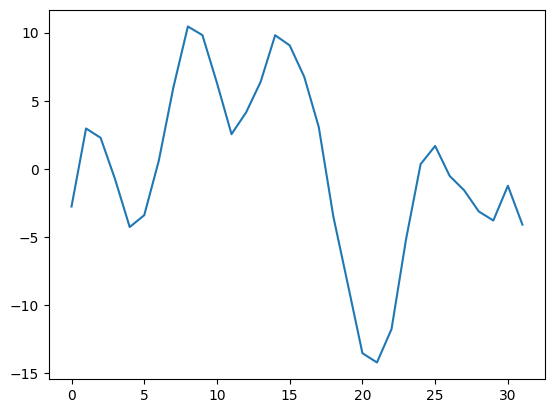

In [7]:
plt.plot(dm.dfds.patterns[2, 1])